# Project Plan - Restaurant Recommendation System

This project is designed to develop a project plan for proposed software development for a group of restaurant owners in Marlborough, Massachussetts. It is described as a "consumer-focused recommendation system" that will consist of the following technologies:

- Alpine.js and Tailwind (Frontend)
- GraphQL (API)
- Go web and database server (Backend)
- Either PostgreSQL, EdgeDB, or PocketBase (Database)
- Cloud hosting (AWS, Azure, or GCP)

The softeare will ingest Yelp reviews of the participating restaurants. Restaurants will be updated monthly and Yelp reviews will be updated daily.

## Part 1 - Problem Setup

Using a provided template for the project plan with required steps, for each step, I have filled out the required team members and the number of hours. I have also provided the hourly rate for each team member role and thus am able to calculate the budget based on these estimates. The project plan also specifies best case scenario, expected scenario and worst case scenario.

The project plan is provided in the data folder.

### Uncertainties

- We have not been given a budget range by the client(s) so we are determining the budget based on a reasonable expectation for quality and budget
- This proposal does not assume any scope change and is based on the assumption that the client has a clear vision of the project. If the client changes the scope, the budget will need to be adjusted accordingly.
- We will need to discuss the ongoing costs of hosting and maintenance with the client to determine the ongoing costs of the project post-launch.

### Additional Notes
- Several steps in the project can be done in parallel, which will help reduce the overall time to completion. These would be:
    - Developing pricing plan and developing implementation plan
    - Writing documentation and unit testing will be done in parallel with development
    - Developing marketing strategy and designing the brochure will be done in collaboration

As we will see below, this overall time to completion will be determined through critical path analysis using the values of each step.

## Step 2 - Model Specification 

An assumption provided is that all contributors to the project charge the same hourly rate. This means that less time for all members decreases the time by the same amount. This a minimization problem regarding cost but also a critical path analysis that will be determined by task dependency and overlap.

Normally we would have decision variables for individual team members but based on the instructions we will assume that all team members are the same hourly rate and there are no constraints on their availability. The decision variables are the number of hours for each task and when they are scheduled. This way we can determine an optimal schedule.

The important parts of determining the critical path are the latest start time and latest end time of each task as well as the tasks they are dependent on. 

## Time Constraints
The constraints are that the start time of each tasks has to be equal to or greater than 0, the sum of all of the task durations has to be equal time to the total project time. 

## Dependency Constraints
The dependency constraints are that the start time of a task is greater than or equal to the end time of the task it is dependent on.

In mathematically terms this would be:

- Let $S_i$ be the start time of task $i$
- Let $D_i$ be the duration of task $i$
- Let $T$ be the total project time
- Let $S_j$ be the start time of task $j$
- Let $D_j$ be the duration of task $j$
- Let $j$ be the task that task $i$ is dependent on

The constraints are as follows:

1. Project completion time constraints: $T \geq S_i + D_i$
2. Precedence constraints: $S_i \geq S_j + D_j$ for all $j$



# Step 3 - Programming

Below is the code to solve the optimization problem for the project plan. We will use the PuLP library to solve the linear programming problem. We will use the provided data to determine the optimal schedule for the project plan.

In [3]:
# First, defined the tasks and their durations based on the completed spreadsheet. I have chosen to use a list for the durations for best-case, expected, and worst-case scenarios.

# List of all tasks
tasks = ['A', 'B', 'C', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'E', 'F', 'G', 'H']

# Expected durations (in hours)
durations = {
    'A': [4,8,12],
    'B': [8,12,16],
    'C': [6,10,14],
    'D1': [12,16,20],
    'D2': [16,24,32],
    'D3': [16,24,32],
    'D4': [40,60,80],
    'D5': [8,12,16],
    'D6': [16,24,32],
    'D7': [16,24,32],
    'D8': [4,8,12],
    'E': [8,12,16],
    'F': [6,8,12],
    'G': [8,12,16],
    'H': [6,8,10]
}

# Immediate predecessors
predecessors = {
    'A': [],
    'B': [],
    'C': ['A'],
    'D1': ['A'],
    'D2': ['D1'],
    'D3': ['D1'],
    'D4': ['D2', 'D3'],
    'D5': ['D4'],
    'D6': ['D4'],
    'D7': ['D6'],
    'D8': ['D5', 'D7'],
    'E': ['B', 'C'],
    'F': ['D8', 'E'],
    'G': ['A', 'D8'],
    'H': ['F', 'G']
}

Now run the PuLP code to solve the optimization problem.

In [14]:
import pulp
import os

# Scenario names and indices
scenarios = ['Best-Case', 'Expected', 'Worst-Case']
scenario_indices = [0, 1, 2]

# Uniform hourly rate (adjust as needed)
hourly_rate = 60  # dollars per hour

# Build successors dictionary
successors = {task: [] for task in tasks}
for task, preds in predecessors.items():
    for pred in preds:
        successors[pred].append(task)

# Initialize a dictionary to store results for each scenario
scenario_results = {}

# Set the output directory and ensure it exists
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

for scenario_name, idx in zip(scenarios, scenario_indices):
    print(f"--- {scenario_name} Scenario ---\n")
    
    # Extract durations for the current scenario
    scenario_durations = {task: durations[task][idx] for task in tasks}
    
    # Initialize the LP problem
    prob = pulp.LpProblem(f"Project_Scheduling_{scenario_name}", pulp.LpMinimize)
    
    # Define decision variables
    S = {task: pulp.LpVariable(f"S_{task}_{scenario_name}", lowBound=0) for task in tasks}
    T = pulp.LpVariable(f"T_{scenario_name}", lowBound=0)
    
    # Set the objective function
    prob += T, "Minimize_Project_Completion_Time"
    
    # Add constraints
    # 1. Project completion time constraints
    for task in tasks:
        prob += T >= S[task] + scenario_durations[task], f"Completion_Time_{task}_{scenario_name}"
    
    # 2. Precedence constraints
    for task, preds in predecessors.items():
        for pred in preds:
            prob += S[task] >= S[pred] + scenario_durations[pred], f"Precedence_{pred}_to_{task}_{scenario_name}"
    
    # Solve the LP problem
    prob.solve()
    
    # Create a text file to store the results for the current scenario
    with open(f"{output_dir}/output_{scenario_name.lower()}.txt", "w") as f:
        # Print and write the status of the solution
        result_status = f"Status: {pulp.LpStatus[prob.status]}"
        print(result_status)
        f.write(result_status + "\n")
        
        if pulp.LpStatus[prob.status] == 'Optimal':
            # Extract earliest start and finish times
            ES = {task: S[task].varValue for task in tasks}
            EF = {task: ES[task] + scenario_durations[task] for task in tasks}
            
            # Initialize latest finish times
            LF = {task: None for task in tasks}
            LS = {task: None for task in tasks}
            
            # Tasks with no successors have LF equal to project completion time
            for task in tasks:
                if not successors[task]:
                    LF[task] = T.varValue
                    LS[task] = LF[task] - scenario_durations[task]
            
            # Perform backward pass
            tasks_rev = sorted(tasks, key=lambda x: EF[x], reverse=True)
            
            for task in tasks_rev:
                if LF[task] is None:
                    LF[task] = min([LS[succ] for succ in successors[task]])
                    LS[task] = LF[task] - scenario_durations[task]
            
            # Calculate slack
            slack = {task: LS[task] - ES[task] for task in tasks}
            
            # Store the results for this scenario
            scenario_results[scenario_name] = {
                'ES': ES,
                'EF': EF,
                'LS': LS,
                'LF': LF,
                'slack': slack,
                'scenario_durations': scenario_durations,
                'T': T.varValue
            }
            
            # Print and write task times and slack
            print("\nTask Times and Slack:")
            f.write("\nTask Times and Slack:\n")
            for task in tasks:
                result_line = (f"Task {task}: ES = {ES[task]}, EF = {EF[task]}, LS = {LS[task]}, LF = {LF[task]}, Slack = {slack[task]}")
                print(result_line)
                f.write(result_line + "\n")
            
            # Identify critical path
            print("\nTasks on the critical path:")
            f.write("\nTasks on the critical path:\n")
            for task in tasks:
                if abs(slack[task]) < 1e-6:
                    print(f" - Task {task}")
                    f.write(f" - Task {task}\n")
            
            # Print and write total project completion time
            total_project_time = f"\nTotal project completion time: {T.varValue} hours"
            print(total_project_time)
            f.write(total_project_time + "\n")
            
            # Calculate and print/write total project cost
            total_hours = sum(scenario_durations.values())
            total_cost = hourly_rate * total_hours
            total_project_cost = f"Total project cost: ${total_cost}"
            print(total_project_cost)
            f.write(total_project_cost + "\n")
        else:
            print("No optimal solution found.")
            f.write("No optimal solution found.\n")
        
    print("\n" + "="*50 + "\n")


--- Best-Case Scenario ---

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mattmiller/Sites/Decision Analytics - Assignment 2/.venv/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/4_/vbtv64ld2lv61jz5x9sljn5h0000gn/T/a9b1ddfdfbb145fabe450d3b48b6f304-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/4_/vbtv64ld2lv61jz5x9sljn5h0000gn/T/a9b1ddfdfbb145fabe450d3b48b6f304-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 109 RHS
At line 144 BOUNDS
At line 145 ENDATA
Problem MODEL has 34 rows, 16 columns and 68 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-34) rows, 0 (-16) columns and 0 (-68) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 122
After Postsolve, objective 122, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 122 - 0 itera

I have chosen to output Gantt charts using matplotlib rather than build them manually. Below is my code to demonstrate that.

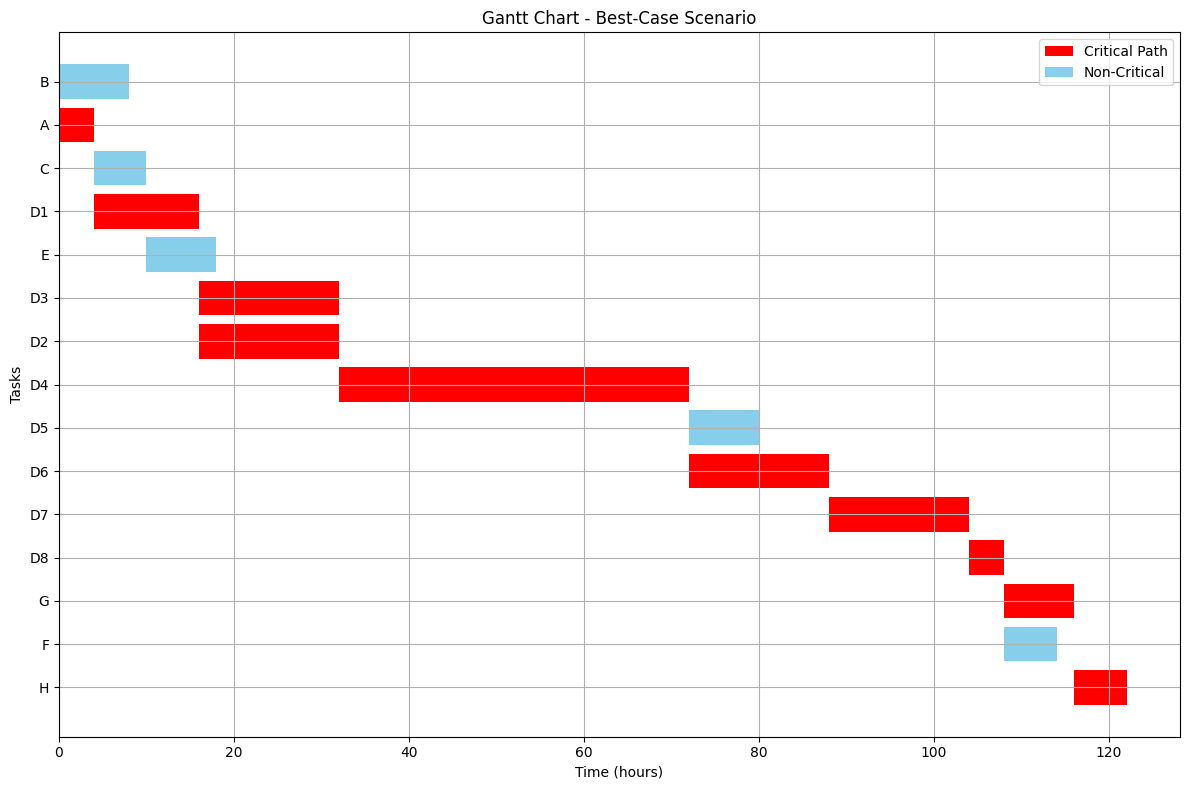

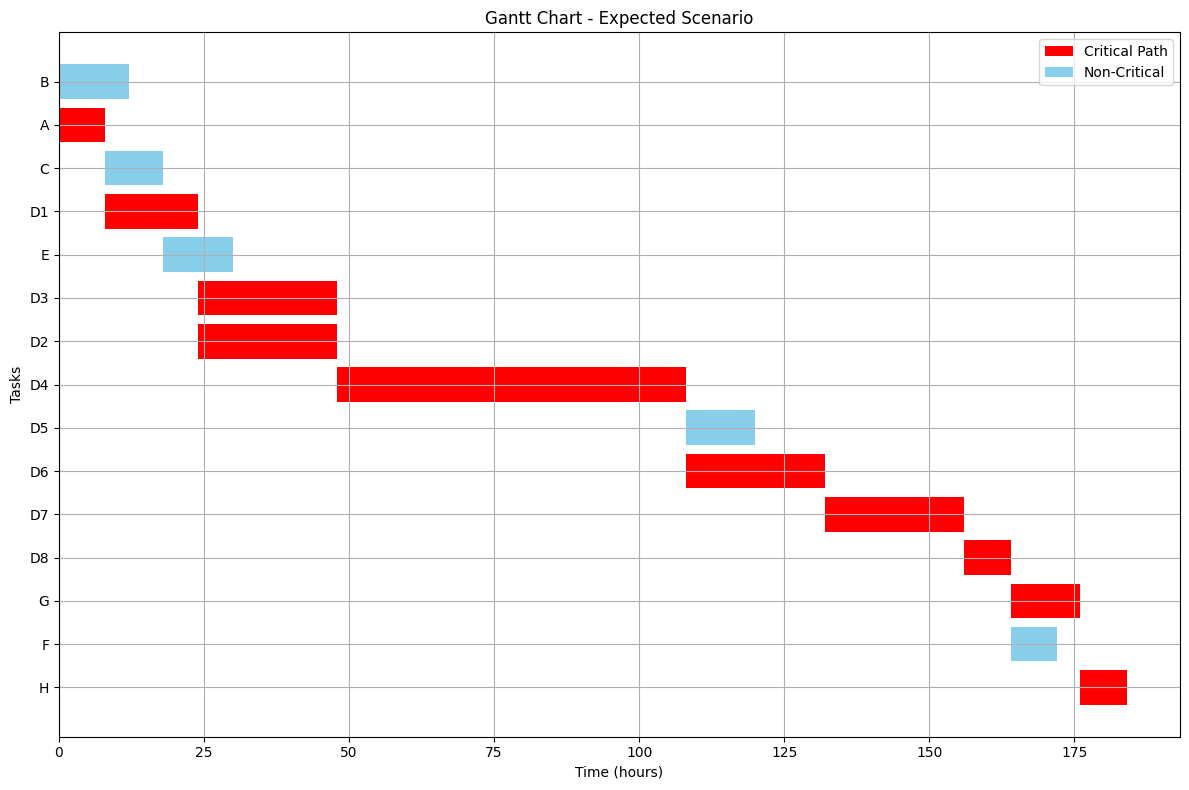

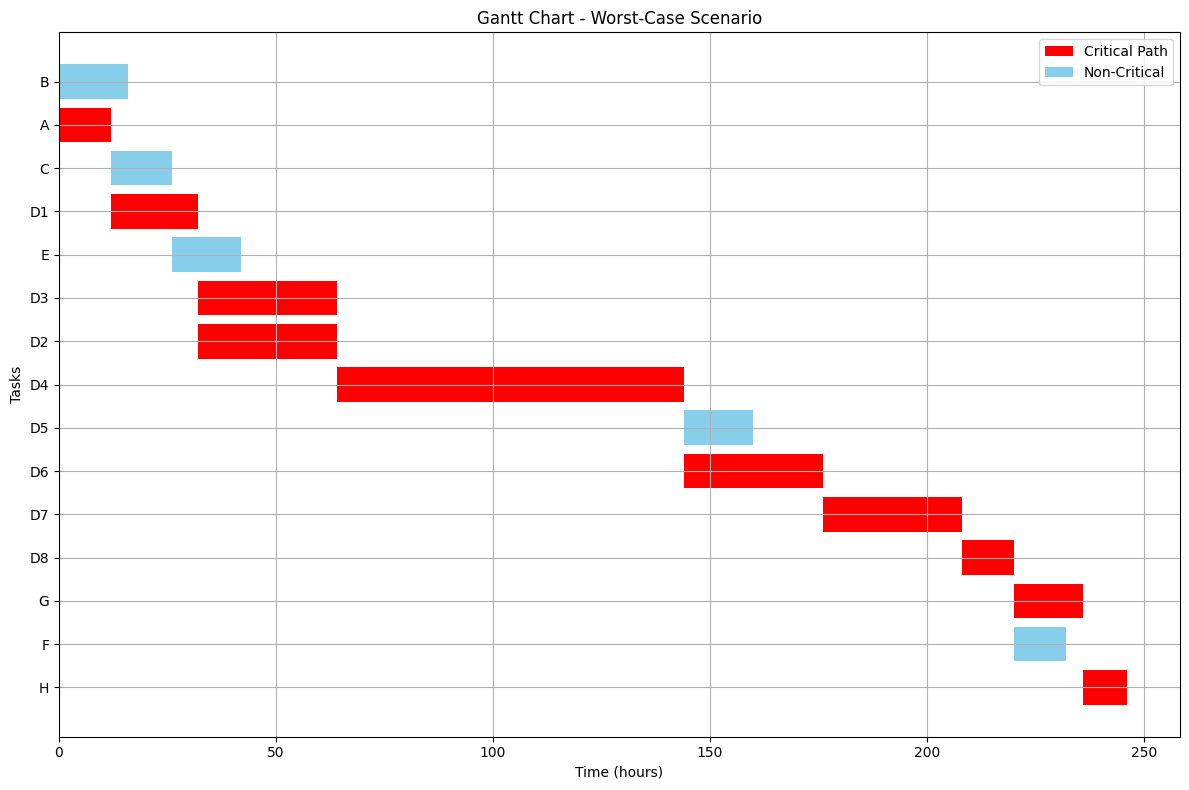

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import os

output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# Generate Gantt charts for each scenario
for scenario_name in scenarios:
    if scenario_name in scenario_results:
        ES = scenario_results[scenario_name]['ES']
        slack = scenario_results[scenario_name]['slack']
        scenario_durations = scenario_results[scenario_name]['scenario_durations']
        T = scenario_results[scenario_name]['T']
        
        # Prepare the data for the Gantt chart
        task_data = []
        for task in tasks:
            task_dict = {
                'Task': task,
                'Start': ES[task],
                'Duration': scenario_durations[task],
                'Finish': ES[task] + scenario_durations[task],
                'Critical': abs(slack[task]) < 1e-6  # True if task is on critical path
            }
            task_data.append(task_dict)
        
        # Create a DataFrame
        df = pd.DataFrame(task_data)
        
        # Sort tasks for better visualization
        df = df.sort_values(by='Start', ascending=False)
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Assign colors based on critical path
        colors = ['red' if critical else 'skyblue' for critical in df['Critical']]
        
        # Plot the bars
        ax.barh(df['Task'], df['Duration'], left=df['Start'], color=colors)
        
        # Customize the plot
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('Tasks')
        ax.set_title(f'Gantt Chart - {scenario_name} Scenario')
        ax.grid(True)
        
        # Create a legend
        legend_elements = [
            Patch(facecolor='red', label='Critical Path'),
            Patch(facecolor='skyblue', label='Non-Critical')
        ]
        ax.legend(handles=legend_elements)
        
        plt.tight_layout()
        plt.show()
        
        # Save the plot
        fig.savefig(f"{output_dir}/gantt_{scenario_name.lower()}.png")
    else:
        print(f"No results for scenario {scenario_name}")


# Step 4 - Solution

The solutions for each scenario are as follows:

Best-Case:  
Total project completion time: 122 hours  
Total project cost: 10440 dollars
  
Expected:  
Total project completion time: 184 hours  
Total project cost: 15720 dollars  
  
Worst-Case:  
Total project completion time: 246 hours  
Total project cost: 21120 dollars  

In the above code, I have run the solution for all three scenarios (best-case, expected, and worst-case). The code calculates the earliest start (ES) and finish (EF) times, latest start (LS) and finish (LF) times, slack, and critical path for each task. It also calculates the total project completion time and cost. The results are displayed for each scenario.

The critical path is the sequence of tasks that determines the total project completion time. Since certain tasks are dependent on other tasks, there are several paths through the project. For example, you can see that Task B (Develop marketing strategy) only has Task E relying on it, so theoretically it can have a much later start time than the other tasks (hence, it's ES value of 0 and its LS value of 144 in the expected scenario, for example).

To be more specific about criticality, the critical path items, as viewed in the Gantt charts are tasks that, if they are delayed or go over time, would delay the full completion of the process.

# Step 5 - Overview

I have quite a bit of experience building software for clients (it has been my job for the past twelve years) so this process is quite familiar to me.

In my experience, clients almost always undervalue the effort is takes to build software and, due to this, not only underestimate budget but also. Additionally, items out of scope they feel are trivial tend to create conflict and eat into our teams overall budget.

I would likely present the worst-case scenario budget with an additional 15% added. I would make sure I'm making at least a 25% margin on what I pay the contractors. This way I have padding where I hopefully can deliver the project under the worst-case scenario and also have padding in my margin for any unexpected costs if things go way out of hand.

One of the major reasons for the caution is that there are a few critical parts of the project plan template that I feel are missing. The first is the UI/UX design phase. This would drive the requirements analysis and is often where the client is the most critical because they have a visual representation of what they are envisioning. This, in my experience, tends to be the most difficult part of any process and, if done correctly, sets the development team up for success or failure. Although 'software design' is included in the template, I find this to be more about the architecture of the software and not the user experience.

The other part that is missing is the client testing and iteration. In order to gain approval from the client (and thus get paid in full), it is important that the client has enough time with the product to give meaningful notes and that the development team has enough time to iterate on those notes.